# Data Smart Sans Excel
[Data Smart](http://www.john-foreman.com/data-smart-book.html) is a data science book written by John Forman (of MailChimp). The book is very hands-on, with lots of exercises / examples. John wanted it to be a "code free" book (at least for the first few chapters), so he uses Excel as the primary data tool. I thought it would be a helpful learning exercise to work the problems in the book with python. 

In [41]:
# Download and extract Data Smart files
import os
import urllib.request
import zipfile
if not os.path.exists(os.path.join(os.getcwd(), "data_smart_files")):
    r = range(1, 11)
    url_list = []
    url_base = "http://media.wiley.com/product_ancillary/6X/11186614/DOWNLOAD/"
    for i in r:
        url_list.append(url_base + 'ch' + str(i).zfill(2) + '.zip')
    for url in url_list:
        file_name = url[-8:]
        urllib.request.urlretrieve (url, file_name)
        z = zipfile.ZipFile(file_name, "r")
        z.extractall(os.path.join(os.getcwd(), "data_smart_files"))
        z.close()

## Chapter 2 - K-means Clustering

In [42]:
import pandas as pd
import numpy as np
excel_file = os.path.join(os.getcwd(), "data_smart_files", "ch02", "WineKMC.xlsx")
offer_info_df = pd.read_excel(excel_file, 'OfferInformation', index_col=0)
tranactions_df = pd.read_excel(excel_file, 'Transactions')

transactions_pt = pd.pivot_table(tranactions_df,index=["Offer #"],columns=["Customer Last Name"],
                    values=['Offer #'],aggfunc=[np.count_nonzero],fill_value=0)
#for some reason an extra 1 was being added to each nonzero count, so i subtracted 1.
transactions_pt = transactions_pt.applymap(lambda x: max(0,x-1))
transactions_np = transactions_pt.values

We now have the details about the offers in a dataframe along with which customers bought which deals.
Next we want to solve for our K clusters by minimizing the distance between the cluster centers and the cluster members.

In the code below:
* X is the dataset where a row is a single data point
* idx is the centroid assignmnet assignment vector (each entry is a cluster b/t 0 and K)
* K = number of clusters

### K-Cluster Code

In [43]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import numpy as np    
import time

# Note: some of the below code was generated during Andrew Ng's Machine Learning class. 
# It likely includes some of the starter code he provided. 

def distance(X, centroids,K):
    X = X.T
    distance = np.zeros((centroids.shape[0],X.shape[1]))
    for i in range(0,K):
        distance[i,:] = np.sqrt((np.apply_along_axis(lambda x: x**2,0,(X.T - centroids[i]))).sum(axis=1))
    dist_min = np.min(distance, axis=0)
    total_dist = np.sum(dist_min)
    return total_dist 

def plot_init(max_iters, m, n, K):
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.set_xlabel('Time')
    ax0.set_ylabel('Total Distance')
    ax1.set_xlabel('Offers')
    ax1.set_ylabel('Clusters')
    ax1.set_xlim(-0.5,n - 0.5)
    ax1.set_ylim(-0.5,K - 0.5)
    return fig, [ax0, ax1]

def runkMeans(X, initial_centroids, max_iters, plot_progress=False):
    # runs the K-Means algorithm on data matrix X, where each 
    # row of X is a single example. It uses initial_centroids used as the
    # initial centroids. max_iters specifies the total number of interactions 
    # of K-Means to execute. plot_progress is a true/false flag that 
    # indicates if the function should also plot its progress as the 
    # learning happens. This is set to false by default. runkMeans returns 
    # centroids, a Kxn matrix of the computed centroids and idx, a m x 1 
    # vector of centroid assignments (i.e. each entry in range [1..K])

    m, n = X.shape
    K = np.array(initial_centroids).shape[0]
    centroids = initial_centroids
    starter_centroids = centroids
    idx = np.zeros((m, 1))
    d = []
    # Run K-Means
    if plot_progress: 
        fig, [ax0, ax1] = plot_init(max_iters, m, n, K)  
        x_values = np.linspace(0,max_iters,max_iters)        
        y_values = np.zeros(max_iters)    

    for i in range(max_iters):
        # For each example in X, assign it to the closest centroid
        idx = findClosestCentroids(X, centroids)
        # compute new centroids
        centroids = computeCentroids(X, idx, K)
        di = distance(X, centroids, K)
        
        if plot_progress:
            # Left Plot
            y_values[i] = di
            if len(ax0.lines):
                ax0.lines[0].set_xdata(x_values)
                ax0.lines[0].set_ydata(y_values)
            else:
                ax0.plot(x_values,y_values)
                
            # Right Plot
            plt.imshow(centroids, cmap='OrRd',  interpolation='nearest', aspect='auto')
            ax1.xaxis.set_major_formatter(ticker.NullFormatter())
            x_ticks = list(range(centroids.shape[1]))
            if len(x_ticks) > 5: 
                def f(x): 
                    if np.mod(x,2) == 0: 
                        return ''
                    else: 
                        return str(x+1)
            else:
                def f(x): 
                    return str(x+1)
            x_tick_lables = list(map(f,x_ticks))
            ax1.xaxis.set_minor_locator(ticker.FixedLocator(x_ticks))
            ax1.xaxis.set_minor_formatter(ticker.FixedFormatter(x_tick_lables))
            ax1.yaxis.set_major_formatter(ticker.NullFormatter())
            y_ticks = list(range(K))
            y_tick_lables = list(map(lambda x:str(x+1),y_ticks))
            ax1.yaxis.set_minor_locator(ticker.FixedLocator(y_ticks))
            ax1.yaxis.set_minor_formatter(ticker.FixedFormatter(y_tick_lables))
            #if len(ax1.lines):
            #    ax1.lines[0].set_xdata(X[0])
            #    ax1.lines[0].set_ydata(X[1])
            #else:
            #    ax1.plot(X[0],X[1])
            plt.tight_layout()
            fig.canvas.draw()
            time.sleep(.05)
    return [centroids, idx, di]            

def computeCentroids(X, idx, K):
    # returns a matrix of centroids, where each row of 
    # centroids is the mean of the data points
    # assigned to it.
    
    m, n = X.shape
    centroids = np.zeros((K, n))
    for cluster in range (K):
        #cycle through centroid assignments
        centroids[cluster] = np.sum(X[np.where(idx == cluster)[0],:],0) / np.sum(idx == cluster)
    return centroids

def findClosestCentroids(X, centroids):
    # computes the centroid memberships for every example
    # function returns the closest centroids in idx
    # for a dataset X where each row is a single example. idx = m x 1 
    # vector of centroid assignments (i.e. each entry in range [1..K])
    
    K = len(centroids)
    m, n = X.shape
    idx = np.zeros((m, 1))
    for i in range(m):
        x = X[i]
        winner = 10 ** 1000
        for j in range(K):
            c = centroids[j]
            d = np.dot(x - c, x - c)
            if d < winner:
                winner = d
                idx[i] = j
    return idx
               
def kMeansInitCentroids(X, K):
    # returns K initial centroids to be
    # used with the K-Means on the dataset X

    m, n = X.shape
    centroids = np.zeros((K, n))
    randidx = np.random.permutation(m)
    centroids = X[randidx[0:K]]
    return centroids

### Clustering with K=4
Run of the K Cluster algorithm 

<IPython.core.display.Javascript object>


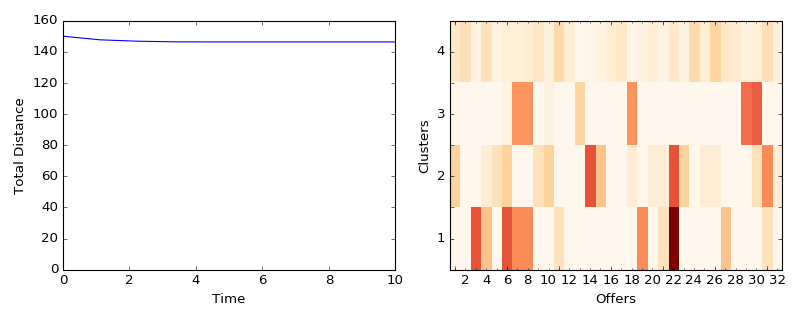

Final Distance: 146.477251


In [44]:
K = 4 # number of clusters
max_iters = 10 # number of iterations
X = transactions_np.T # transpose since algorithm assumes each entry is a row (not column)
initial_centroids = kMeansInitCentroids(X, K)
[centroids_k4, cluster_assignment_k4, di] = runkMeans(X, initial_centroids, max_iters, plot_progress=True)
print ("Final Distance: %f"%di)

Data Smart arrived at a distance of 140.7 using a K of 4... why am I not optimizing as well?
It seems that the cluster definitions stabilize quite quickly (too quickly?) In an attempt to verify the approach, below is a run using a simplified 2-D case of 100 points chosen to create 3 groups which where the centroids can be visually verified.

<IPython.core.display.Javascript object>


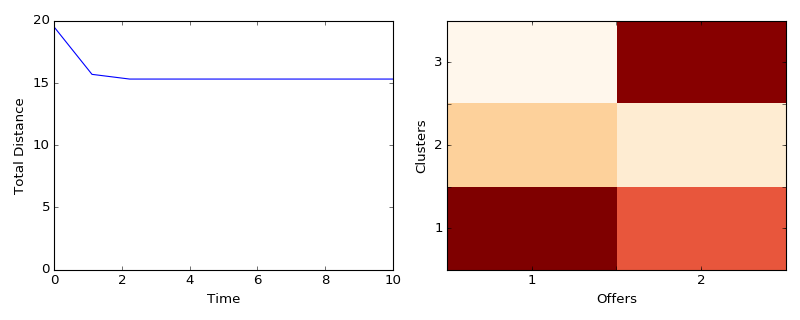

<IPython.core.display.Javascript object>


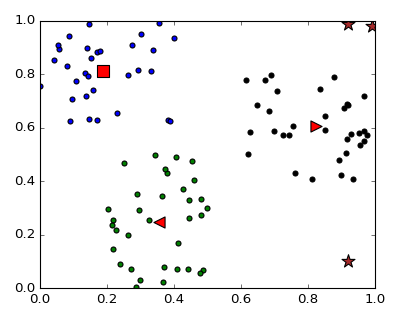

In [45]:
K = 3
max_iters = 10
test_data = np.zeros((100,2))
test_data[:33,0] = np.random.uniform(0, 0.4, 33) #cluster 1, x
test_data[:33,1] = np.random.uniform(0.6, 1, 33) #cluster 1, y
test_data[33:66,0] = np.random.uniform(.6, 1, 33) #cluster 2, x
test_data[33:66,1] = np.random.uniform(.4, 0.8, 33) #cluster 2, y
test_data[66:100,0] = np.random.uniform(0.2, 0.5, 34) #cluster 3, x
test_data[66:100,1] = np.random.uniform(0, 0.5, 34) #cluster 3, y
initial_centroids = np.array([[.99, .98], [.92,.1], [.92, .99]])
[centroids_2Dtest, cluster_assignment_2Dtest, di] = runkMeans(test_data, initial_centroids, max_iters, plot_progress=True)

fig2 = plt.figure(figsize=(5, 4))
gs2 = gridspec.GridSpec(1, 1) 
ax2 = plt.subplot(gs2[0])
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.scatter(test_data[:33,0],test_data[:33,1],c='blue')
ax2.scatter(test_data[33:66,0],test_data[33:66,1],c='black')
ax2.scatter(test_data[66:100,0],test_data[66:100,1],c='green')
ax2.scatter(initial_centroids[:,0],initial_centroids[:,1],c='brown',s=150,marker='*')
sym = ['>','<','s']
for cl in range(K):
    ax2.scatter(centroids_2Dtest[cl,0],centroids_2Dtest[cl,1],c='red',s=100,marker=sym[cl])
plt.tight_layout()
fig2.canvas.draw()
time.sleep(.05)

### Silhouette
#### Distance Matrix

In [46]:
def distance_matrix(X):
    m, n = X.shape
    distance = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            distance[i,j] = np.sqrt(np.apply_along_axis(lambda x: x*x,0,X[j,:] - X[i,:]).sum())
    return distance
distance_mat = distance_matrix(transactions_np.T)

#### Silhouette Calculation


S<sub>i</sub> = (b<sub>i</sub>-a<sub>i</sub>)/max(a<sub>i</sub>, b<sub>i</sub>)
* a<sub>i</sub> = average distance of i to the points in its cluster
* b<sub>i</sub> = min-by-cluster (average distance of i to points in each other cluster)

Here is how to interpret the Silhouette Coefficient (SC):

  Range of SC   | Interpretation
  ------------- | -------------
  0.71 - 1.0    | A strong structure has been found
  0.51 - 0.70   | A reasonable structure has been found
  0.26 - 0.50   | The structure is weak and could be artificial
    < 0.25      | No substantial structure has been found 
A strong structure to the clusters indicates that most observations seem to belong to the cluster that they are in.

In [47]:
def silhouette_calc (distance_mat, cluster_assignment):
    d_df = pd.DataFrame(distance_mat)
    ca_df = pd.DataFrame(cluster_assignment,columns=['C_A'])

    new_df = pd.concat((d_df,ca_df),axis=1)
    a = np.zeros((1,distance_mat.shape[1]))
    for i in range(distance_mat.shape[1]):
        my_cluster = cluster_assignment[i]
        a[0,i] = np.mean(new_df.iloc[:,i].where(new_df['C_A']==my_cluster[0],np.nan))
    b = np.zeros((K,distance_mat.shape[1]))
    for i in range(distance_mat.shape[1]):
        my_cluster = cluster_assignment[i]
        for j in range(K): 
            if j != my_cluster:
                b[j,i] = np.mean(new_df.iloc[:,i].where(new_df['C_A']==j,np.nan))
            else:
                b[j,i] = np.nan
    b = np.nanmin(b,axis=0)
    b = np.reshape(b, (1,distance_mat.shape[0]))
    s = (b - a) / np.amax((a, b),axis=0)
    s = np.average(s)
    return s

silhouette  = silhouette_calc (distance_mat, cluster_assignment_k4)
print ("Silhouette (for K=4): %f"%silhouette)

Silhouette (for K=4): 0.152418


Data Smart calculated an SC of 0.1492, so ours is actually better. 

## Rerun with K = 5

<IPython.core.display.Javascript object>


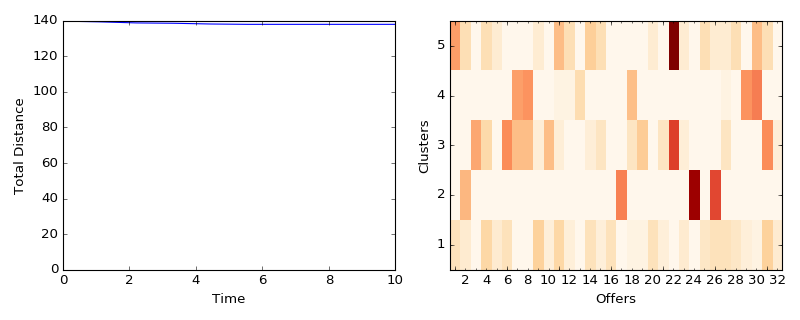

Final Distance: 138.063202
Silhouette (for K=5): 0.089381


In [48]:
K = 5
max_iters = 10
initial_centroids = kMeansInitCentroids(transactions_np.T, K)
[centroids, cluster_assignment_k5, di] = runkMeans(transactions_np.T, initial_centroids, max_iters, plot_progress=True)
distance_mat = distance_matrix(transactions_np)
silhouette  = silhouette_calc (distance_mat, cluster_assignment_k5)
print ("Final Distance: %f"%di)
print ("Silhouette (for K=5): %f"%silhouette)

And here is the silhouette for the 2-D example data I ginned up above. 

In [50]:
K = 3
silhouette  = silhouette_calc (distance_matrix(test_data), cluster_assignment_2Dtest)
print ("Silhouette (for 2D test): %f"%silhouette)

Silhouette (for 2D test): 0.628466
